# Interpreting Identity

# Setup
(No need to read)

In [2]:
TRAIN_MODEL = True

In [3]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
import os

DEVELOPMENT_MODE = True
IN_GITHUB = os.getenv("GITHUB_ACTIONS") == "true"
# Upgrade pip
%pip install --upgrade pip
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")

    # PySvelte is an unmaintained visualization library, use it as a backup if circuitsvis isn't working
    # # Install another version of node that makes PySvelte work way faster
    # !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    # %pip install git+https://github.com/neelnanda-io/PySvelte.git
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")
    ipython.run_line_magic("pip", "install ipympl")
    ipython.run_line_magic("pip", "install scipy")
    ipython.run_line_magic("pip", "install manim")
    ipython.run_line_magic("pip", "install torch")
    ipython.run_line_magic("pip", "install numpy<2")
    ipython.run_line_magic("pip", "install einops")
    ipython.run_line_magic("pip", "install transformer_lens")

if IN_COLAB or IN_GITHUB:
    %pip install transformer_lens
    %pip install circuitsvis
    %pip install ipympl

Note: you may need to restart the kernel to use updated packages.
Running as a Jupyter notebook - intended for development only!


/tmp/ipykernel_429509/2175630693.py:24: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("load_ext autoreload")
/tmp/ipykernel_429509/2175630693.py:25: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("autoreload 2")


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
/bin/bash: Zeile 1: 2: Datei oder Verzeichnis nicht gefunden
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Import stuff
import torch
import numpy as np
import einops
import os
import tqdm.auto as tqdm
from pathlib import Path

import copy

from transformer_lens import HookedTransformer, HookedTransformerConfig, ActivationCache

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
# Define the location to save the model, using a relative path
PTH_LOCATION = "workspace/_scratch/identity.pth"

# Create the directory if it does not exist
os.makedirs(Path(PTH_LOCATION).parent, exist_ok=True)

cuda


# Model Training

## Config

In [5]:
p = 3
frac_train = 1

# Optimizer config
lr = 1e-3
wd = 1e-2
betas = (0.9, 0.999)

num_epochs = 10000
checkpoint_every = 500

DATA_SEED = 598

## Define Task
* Define modular addition
* Define the dataset & labels

Input format:
|a|=|

Convert this to a train + test set - 30% in the training set

In [6]:
def get_training_data(p = p):
    a_vector = torch.arange(p)
    equals_vector = einops.repeat(torch.tensor(p), " -> i", i=p)
    dataset = torch.stack([a_vector, equals_vector], dim=1).to(device)
    print(dataset)
    print(dataset.shape)
    labels = dataset[:, 0]
    print(labels.shape)
    print(labels)
    torch.manual_seed(DATA_SEED)
    indices = torch.randperm(p)
    cutoff = int(p*frac_train)
    train_indices = indices[:cutoff]
    test_indices = indices[cutoff:]

    train_data = dataset[train_indices]
    train_labels = labels[train_indices]
    test_data = dataset[test_indices]
    test_labels = labels[test_indices]
    print(train_data)
    print(train_labels)
    print(train_data.shape)
    print(test_data[:5])
    print(test_labels[:5])
    print(test_data.shape)
    return train_data, train_labels, test_data, test_labels, train_indices, test_indices

train_data, train_labels, test_data, test_labels, train_indices, test_indices = get_training_data(p)

tensor([[0, 3],
        [1, 3],
        [2, 3]], device='cuda:0')
torch.Size([3, 2])
torch.Size([3])
tensor([0, 1, 2], device='cuda:0')
tensor([[2, 3],
        [0, 3],
        [1, 3]], device='cuda:0')
tensor([2, 0, 1], device='cuda:0')
torch.Size([3, 2])
tensor([], device='cuda:0', size=(0, 2), dtype=torch.int64)
tensor([], device='cuda:0', dtype=torch.int64)
torch.Size([0, 2])


## Define Model

In [7]:
def get_seeded_model(seed = 999, p = p):
    cfg = HookedTransformerConfig(
        n_layers = 1,
        n_heads = 1,
        d_model = 2,
        d_head = 2,
        d_mlp = None,
        act_fn = "relu",
        normalization_type=None,
        d_vocab=p+1,
        d_vocab_out=p,
        n_ctx=2,
        init_weights=True,
        device=device,
        seed = seed,
    )
    model = HookedTransformer(cfg)
    for name, param in model.named_parameters():
        if "b_" in name:
            param.requires_grad = False
    return model

model = get_seeded_model(seed = 993)

Disable the biases, as we don't need them for this task and it makes things easier to interpret.

## Define Optimizer + Loss

In [8]:
print(train_data)
print(model(train_data))

tensor([[2, 3],
        [0, 3],
        [1, 3]], device='cuda:0')
tensor([[[-0.2152,  1.8026, -2.0390],
         [-0.2138,  1.7643, -1.9747]],

        [[-0.2440,  1.7854, -1.8153],
         [-0.2454,  2.0402, -2.2953]],

        [[-0.1321,  0.8074, -0.6775],
         [-0.2150,  1.7778, -1.9920]]], device='cuda:0',
       grad_fn=<ViewBackward0>)


In [9]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd, betas=betas)
def loss_fn(logits, labels):
    if len(logits.shape)==3:
        logits = logits[:, -1]
    logits = logits.to(torch.float64)
    log_probs = logits.log_softmax(dim=-1)
    correct_log_probs = log_probs.gather(dim=-1, index=labels[:, None])[:, 0]
    return -correct_log_probs.mean()
train_logits = model(train_data)
train_loss = loss_fn(train_logits, train_labels)
print(train_loss)
test_logits = model(test_data)
test_loss = loss_fn(test_logits, test_labels)
print(test_loss)
print("Uniform loss:")
print(np.log(p))

tensor(2.1438, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(nan, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)
Uniform loss:
1.0986122886681098


## Actually Train

**Weird Decision:** Training the model with full batch training rather than stochastic gradient descent. We do this so to make training smoother and reduce the number of slingshots.

In [10]:
def print_stats(model):
    # Extract the p 2-dimensional tensors, vector i is vec[:, i]
    vec = model.W_U.data

    # Function to compute the angle between two vectors
    def compute_angle(v1, v2):
        cos_theta = torch.dot(v1, v2) / (torch.norm(v1) * torch.norm(v2))
        angle = torch.acos(cos_theta) * (180.0 / np.pi)
        return angle

    # Compute pairwise angles
    for i in range(vec.shape[1]):
        for j in range(i+1, vec.shape[1]):
            angle = compute_angle(vec[:, i], vec[:, j])
            print(f"Angle between {i} and {j}: {angle.item():.2f}°")
        print(f"Norm of vector {i}: {torch.norm(vec[:, i]):.2f}")

print_stats(model)

Angle between 0 and 1: 139.68°
Angle between 0 and 2: 85.21°
Norm of vector 0: 0.29
Angle between 1 and 2: 135.11°
Norm of vector 1: 1.41
Norm of vector 2: 1.76


In [11]:
def train_model(model, train_data, train_labels, test_data, test_labels, train_indices, test_indices, num_epochs = num_epochs):
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=lr, weight_decay=wd, betas=betas
    )
    train_losses = []
    test_losses = []
    model_checkpoints = []
    checkpoint_epochs = []
    if TRAIN_MODEL:
        for epoch in tqdm.tqdm(range(num_epochs)):
            train_logits = model(train_data)
            train_loss = loss_fn(train_logits, train_labels)
            train_loss.backward()
            train_losses.append(train_loss.item())

            optimizer.step()
            optimizer.zero_grad()

            with torch.inference_mode():
                test_logits = model(test_data)
                test_loss = loss_fn(test_logits, test_labels)
                test_losses.append(test_loss.item())

            if ((epoch+1)%checkpoint_every)==0:
                checkpoint_epochs.append(epoch)
                model_checkpoints.append(copy.deepcopy(model.state_dict()))
                print_stats(model)
                print(f"Epoch {epoch} Train Loss {train_loss.item()} Test Loss {test_loss.item()}")
    if TRAIN_MODEL:
        torch.save(
            {
                "model":model.state_dict(),
                "config": model.cfg,
                "checkpoints": model_checkpoints,
                "checkpoint_epochs": checkpoint_epochs,
                "test_losses": test_losses,
                "train_losses": train_losses,
                "train_indices": train_indices,
                "test_indices": test_indices,
            },
            PTH_LOCATION)

train_model(
    model, train_data, train_labels, test_data, test_labels, train_indices, test_indices
)

  0%|          | 0/10000 [00:00<?, ?it/s]

Angle between 0 and 1: 104.45°
Angle between 0 and 2: 120.53°
Norm of vector 0: 0.60
Angle between 1 and 2: 135.02°
Norm of vector 1: 1.39
Norm of vector 2: 2.00
Epoch 499 Train Loss 0.31131555152624474 Test Loss nan
Angle between 0 and 1: 120.91°
Angle between 0 and 2: 119.47°
Norm of vector 0: 1.23
Angle between 1 and 2: 119.63°
Norm of vector 1: 1.53
Norm of vector 2: 2.07
Epoch 999 Train Loss 0.008525104021990497 Test Loss nan
Angle between 0 and 1: 123.98°
Angle between 0 and 2: 119.51°
Norm of vector 0: 1.34
Angle between 1 and 2: 116.51°
Norm of vector 1: 1.57
Norm of vector 2: 2.07
Epoch 1499 Train Loss 0.0017868573880454141 Test Loss nan
Angle between 0 and 1: 125.37°
Angle between 0 and 2: 119.63°
Norm of vector 0: 1.39
Angle between 1 and 2: 115.00°
Norm of vector 1: 1.58
Norm of vector 2: 2.07
Epoch 1999 Train Loss 0.0007601754986202407 Test Loss nan
Angle between 0 and 1: 126.30°
Angle between 0 and 2: 119.74°
Norm of vector 0: 1.42
Angle between 1 and 2: 113.96°
Norm of v

In [12]:
if not TRAIN_MODEL:
    cached_data = torch.load(PTH_LOCATION)
    model.load_state_dict(cached_data['model'])
    model_checkpoints = cached_data["checkpoints"]
    checkpoint_epochs = cached_data["checkpoint_epochs"]
    test_losses = cached_data['test_losses']
    train_losses = cached_data['train_losses']
    train_indices = cached_data["train_indices"]
    test_indices = cached_data["test_indices"]

# Look at weights

## Embedding weights

In [13]:
from scipy.linalg import qr

print(model.embed.W_E.data)
print(model.embed.W_E.data.shape)

# Print information about the embedding matrix (shape p+1 x 2),
# and the positional encoding
W_E = model.embed.W_E.data.cpu().numpy()
pos = model.W_E_pos.data.cpu().numpy()
for i in range(W_E.shape[0]):
    print(f"Norm of token {i}: {np.linalg.norm(W_E[i])}")
    index = (p+1 if i < p else p+2)
    print(f"Embedding: {pos[index]}")
    W_E[i] += pos[index]


# Create a matrix with tensor[0] as the first column
ttr = W_E.transpose()
print(ttr)

# Perform QR decomposition to obtain an orthonormal matrix
Q, R = qr(ttr)

print("Q: ", Q)
print("R: ", R)
print(np.matmul(Q, R))

def get_angle(a, b):
    return np.arccos(
        np.dot(a, b)
        / (np.linalg.norm(a) * np.linalg.norm(b))
    ) / np.pi * 180

dot_product = np.dot(W_E[0], W_E[p])
print(dot_product, get_angle(W_E[0], W_E[p]))
product2 = np.dot(R[:, 0], R[:, p])
print(product2, get_angle(R[:, 0], R[:, p]))

tensor([[ 0.4509, -0.2162],
        [-1.2585, -0.3647],
        [ 1.1159,  0.3321],
        [ 0.3213,  0.2813]], device='cuda:0')
torch.Size([4, 2])
Norm of token 0: 0.5000003576278687
Embedding: [ 0.11285752 -0.48909295]
Norm of token 1: 1.3102654218673706
Embedding: [ 0.11285752 -0.48909295]
Norm of token 2: 1.1642929315567017
Embedding: [ 0.11285752 -0.48909295]
Norm of token 3: 0.4269903898239136
Embedding: [ 1.1846437  -0.26378855]
[[ 0.56371    -1.1456406   1.2287819   1.5059134 ]
 [-0.7052697  -0.8537545  -0.15699235  0.01747048]]
Q:  [[-0.6243534  0.781142 ]
 [ 0.781142   0.6243534]]
R:  [[-0.90287006  0.04838121 -0.8898275  -0.9265753 ]
 [ 0.         -1.4279526   0.86183447  1.18724   ]]
[[ 0.56371    -1.1456407   1.2287819   1.5059135 ]
 [-0.7052697  -0.8537545  -0.15699236  0.01747045]]
0.836577 52.029926
0.8365771 52.029926


U= tensor([[-0.8053,  0.5929],
        [ 0.5929,  0.8053]]) 
S= [2.3727198  0.11259287] 
V= tensor([[ 0.6545,  0.7560],
        [-0.7560,  0.6545]])
U= tensor([[-0.8053,  0.5929],
        [ 0.5929,  0.8053]]) 
S= [2.3727198  0.11259287] 
V= tensor([[ 0.6545,  0.7560],
        [-0.7560,  0.6545]])


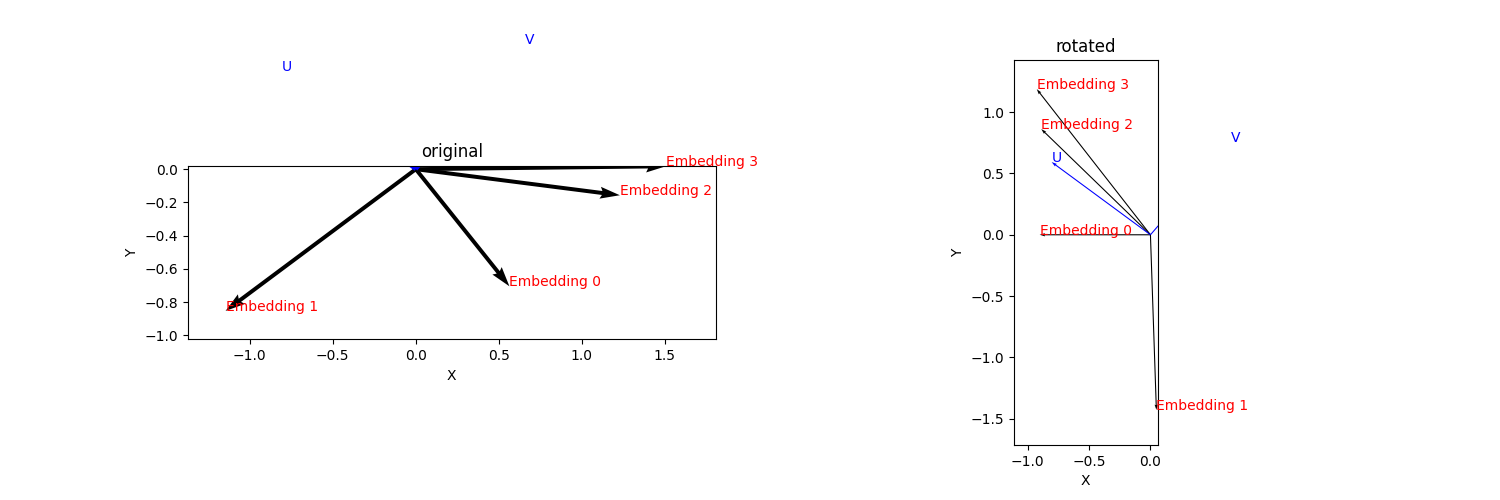

In [14]:
import matplotlib.pyplot as plt
import numpy as n

%matplotlib widget

plt.close('all')

def plot_tensor(fig, tensor, position = 111, title = ""):
    ax = fig.add_subplot(position)
    ax.set_title(title)

    # Define the origin
    origin = np.zeros((p+1, 2))

    # Plot the arrows
    for i in range(tensor.shape[0]):
        ax.quiver(origin[i, 0], origin[i, 1], 
                tensor[i, 0], tensor[i, 1],
                angles='xy', scale_units='xy', scale=1)

        ax.text(tensor[i, 0], tensor[i, 1], f"Embedding {i}", color='red')
    W_Q = model.blocks[0].attn.W_Q.data[0]
    W_K = model.blocks[0].attn.W_K.data[0].transpose(0, 1)
    W_QK = torch.matmul(W_Q, W_K)
    U, S, V = np.linalg.svd(W_QK.cpu())
    print("U=", U, "\nS=", S, "\nV=", V)
    
    ax.quiver(origin[i, 0], origin[i, 1], U[0, 0], U[0, 1], angles='xy', scale_units='xy', scale=1, color='blue')
    ax.text(U[0, 0], U[0, 1], f"U", color='blue')
    ax.quiver(origin[i, 0], origin[i, 1], V[0, 0], V[0, 1], angles='xy', scale_units='xy', scale=1, color='blue')
    ax.text(V[0, 0], V[0, 1], f"V", color='blue')

    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xlim(min(tensor[:, 0].min(), 0)*1.2, max(tensor[:, 0].max(), 0) * 1.2)
    ax.set_aspect('equal')
    ax.set_ylim(min(tensor[:, 1].min(), 0)*1.2, max(tensor[:, 1].max(), 0) * 1.2)

fig = plt.figure(figsize=(15, 5))
plot_tensor(fig, W_E, 121, "original")
plot_tensor(fig, R.transpose(), 122, "rotated")
plt.show()

# Unembedding weights

In [15]:
W_U = model.unembed.W_U.data.cpu().numpy()

print(W_U)

Qrev, Rrev = qr(W_U)

print("Q_U=", Qrev)
print("R_U=", Rrev)

print("W_E=", W_E)
print("W_U=", W_U)

product = np.matmul(W_E, W_U)
print(product)

rank = np.linalg.matrix_rank(product)
print(rank)

[[ 1.5492015  -0.6270662  -1.5552962 ]
 [ 0.55163884 -1.480918    1.2604997 ]]
Q_U= [[-0.9420589  -0.33544782]
 [-0.33544782  0.9420588 ]]
R_U= [[-1.6444849  1.0875039  1.0423489]
 [ 0.        -1.1847639  1.7091856]]
W_E= [[ 0.56371    -0.7052697 ]
 [-1.1456406  -0.8537545 ]
 [ 1.2287819  -0.15699235]
 [ 1.5059134   0.01747048]]
W_U= [[ 1.5492015  -0.6270662  -1.5552962 ]
 [ 0.55163884 -1.480918    1.2604997 ]]
[[ 0.48424616  0.69096315 -1.7657282 ]
 [-2.2457924   1.982733    0.7056532 ]
 [ 1.8170278  -0.5380348  -2.1090086 ]
 [ 2.3426006  -0.97017974 -2.3201199 ]]
2


# Activations

In [16]:
def create_cache(model, p = p):
    input = torch.stack([torch.arange(p), torch.full((p,), p)], dim=1)
    print(input)
    logits, cache = model.run_with_cache(input)
    print(logits)
    return cache

cache = create_cache(model)

tensor([[0, 3],
        [1, 3],
        [2, 3]])
tensor([[[  1.5498,   0.0793,  -2.5752],
         [  7.7092,  -4.4048,  -5.8867]],

        [[-13.1350,  13.8477,   0.8795],
         [ -3.9407,   9.2153,  -7.0371]],

        [[ -2.9986,  -2.9731,   9.0504],
         [ -3.2913,  -3.6794,  10.5342]]], device='cuda:0',
       grad_fn=<ViewBackward0>)


In [17]:
W_K = model.blocks[0].attn.W_K.data[0].cpu()
W_Q = model.blocks[0].attn.W_Q.data[0].cpu()
print("W_K: ", W_K)
W_K_T = torch.transpose(W_K, 0, 1)
W_QK = torch.matmul(W_Q, W_K_T)
print("W_Q: ", W_Q)
print("W_K transposed: ", W_K_T)
print(W_QK)
W_V = model.blocks[0].attn.W_V.data[0].cpu()
W_O = model.blocks[0].attn.W_O.data[0].cpu()
W_VO = torch.matmul(W_V, W_O)
print(W_VO)
W_E = model.embed.W_E.data.cpu().numpy()
U, S, V = np.linalg.svd(W_QK)
print("U: ", U)
print("S: ", S)
print("V: ", V)
S_rank_1 = np.zeros((2, 2))
S_rank_1[0, 0] = S[0]
print("S_rank_1: ", S_rank_1)
W_QK_rank_1 = np.matmul(np.matmul(U, S_rank_1), V)
print("W_QK_rank_1: ", W_QK_rank_1)

W_K:  tensor([[ 1.2070, -0.8092],
        [ 1.0230, -1.1796]])
W_Q:  tensor([[-0.6733,  0.6037],
        [ 0.1622, -0.8112]])
W_K transposed:  tensor([[ 1.2070,  1.0230],
        [-0.8092, -1.1796]])
tensor([[-1.3011, -1.4009],
        [ 0.8522,  1.1229]])
tensor([[-0.8883,  1.8240],
        [-1.2382,  0.6854]])
U:  tensor([[-0.8053,  0.5929],
        [ 0.5929,  0.8053]])
S:  [2.3727198  0.11259287]
V:  tensor([[ 0.6545,  0.7560],
        [-0.7560,  0.6545]])
S_rank_1:  [[2.37271976 0.        ]
 [0.         0.        ]]
W_QK_rank_1:  tensor([[-1.2507, -1.4446],
        [ 0.9208,  1.0635]], dtype=torch.float64)


/tmp/ipykernel_429509/2174224632.py:21: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  W_QK_rank_1 = np.matmul(np.matmul(U, S_rank_1), V)


In [18]:
cache.cache_dict

{'hook_embed': tensor([[[ 0.4509, -0.2162],
          [ 0.3213,  0.2813]],
 
         [[-1.2585, -0.3647],
          [ 0.3213,  0.2813]],
 
         [[ 1.1159,  0.3321],
          [ 0.3213,  0.2813]]], device='cuda:0'),
 'hook_pos_embed': tensor([[[ 0.1129, -0.4891],
          [ 1.1846, -0.2638]],
 
         [[ 0.1129, -0.4891],
          [ 1.1846, -0.2638]],
 
         [[ 0.1129, -0.4891],
          [ 1.1846, -0.2638]]], device='cuda:0'),
 'blocks.0.hook_resid_pre': tensor([[[ 0.5637, -0.7053],
          [ 1.5059,  0.0175]],
 
         [[-1.1456, -0.8538],
          [ 1.5059,  0.0175]],
 
         [[ 1.2288, -0.1570],
          [ 1.5059,  0.0175]]], device='cuda:0'),
 'blocks.0.attn.hook_q': tensor([[[[-4.9392e-01,  9.1244e-01]],
 
          [[-1.0110e+00,  8.9494e-01]]],
 
 
         [[[ 6.3284e-01,  9.7185e-04]],
 
          [[-1.0110e+00,  8.9494e-01]]],
 
 
         [[[-8.5276e-01,  8.6917e-01]],
 
          [[-1.0110e+00,  8.9494e-01]]]], device='cuda:0'),
 'blocks.0.attn.hook_k'

# Animations

In [19]:
from manim import *

config.media_width = "80%"
config.verbosity = "WARNING"
config.preview = False

/home/pweiss/Research/.venv/lib/python3.12/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [20]:
class VectorParams:
    def __init__(self, values = [], color = WHITE):
        self.values = values
        self.color = color
    def __repr__(self) -> str:
        return str(self.values) + "(" + str(self.color) + ")"

class Data:
    def __init__(self):
        self.vectors: list[list[VectorParams]] = [[]]
        self.steps = 0

    def add_vector(self, vector, color = WHITE):
        self.vectors[self.steps].append(VectorParams(values = vector, color = color))

    def next_step(self):
        self.steps += 1
        self.vectors.append([])

    def add_vectors_at_hook(self, c: ActivationCache, hook: str, color0 = WHITE, color1 = WHITE):
        for i in range(c.cache_dict[hook].shape[0]):
            self.add_vector(c.cache_dict[hook][i][0].cpu(), color = color0)
            self.add_vector(c.cache_dict[hook][i][1].cpu(), color = color1)

def compile_data_vectors(cache):
    vectors = Data()
    vectors.add_vectors_at_hook(cache, "hook_embed", color1 = GRAY)
    vectors.next_step()
    vectors.add_vectors_at_hook(cache, "blocks.0.hook_resid_pre")
    vectors.next_step()
    vectors.add_vectors_at_hook(cache, "blocks.0.hook_resid_mid", color0 = GRAY)
    #vectors.add_vectors_at_hook(cache, "blocks.0.hook_resid_post")

    print(vectors.vectors)
    return vectors
vectors = compile_data_vectors(cache)

[[tensor([ 0.4509, -0.2162])(#FFFFFF), tensor([0.3213, 0.2813])(#888888), tensor([-1.2585, -0.3647])(#FFFFFF), tensor([0.3213, 0.2813])(#888888), tensor([1.1159, 0.3321])(#FFFFFF), tensor([0.3213, 0.2813])(#888888)], [tensor([ 0.5637, -0.7053])(#FFFFFF), tensor([1.5059, 0.0175])(#FFFFFF), tensor([-1.1456, -0.8538])(#FFFFFF), tensor([1.5059, 0.0175])(#FFFFFF), tensor([ 1.2288, -0.1570])(#FFFFFF), tensor([1.5059, 0.0175])(#FFFFFF)], [tensor([ 0.9362, -0.1605])(#888888), tensor([1.7295, 0.7526])(#FFFFFF), tensor([ 0.9291, -3.5286])(#888888), tensor([ 3.5561, -2.6185])(#FFFFFF), tensor([0.3317, 1.9767])(#888888), tensor([0.4491, 2.3671])(#FFFFFF)]]


In [31]:
def change_font_size(labeled_arrow: LabeledArrow, new_size):
    # print(labeled_arrow, labeled_arrow.submobjects)
    # print(labeled_arrow.submobjects[-1].font_size)
    return
    # TODO: Fix this
    if not isinstance(labeled_arrow, LabeledArrow):
        return
    label = labeled_arrow.submobjects[-1]
    box = labeled_arrow.submobjects[-2]
    if not isinstance(box, BackgroundRectangle):
        box = labeled_arrow.submobjects[-3]
    coords = label.get_center()
    # print(new_size)
    labeled_arrow.submobjects[-1] = MathTex(
        label.get_tex_string(), color=label.color, font_size=new_size
    )
    # print("size=", labeled_arrow.submobjects[-1].font_size)
    label = labeled_arrow.submobjects[-1]
    label.move_to(coords)
    box.width = label.width + 2 * box.buff
    box.height = label.height + 2 * box.buff

In [32]:
class VisualizeTransformer(MovingCameraScene):
    def construct(self):
        print("v=", vectors.vectors)
        axes = Axes(
            x_range = [-20, 20, 1],
            y_range = [-20, 20, 1],
            x_axis_config={
                "numbers_to_include": np.arange(-18, 18.1, 3),
                "font_size": 24
            },
            y_axis_config={
                "numbers_to_include": np.arange(-18, 18.1, 3), 
                "font_size": 24            
            },
            x_length = 40,
            y_length = 40,
            axis_config={"color": GREEN}
        )
        axes_labels = axes.get_axis_labels()

        scale = ValueTracker(2)

        arrows = VGroup()
        def update_scale(self):
            self.stroke_width = 6 * scale.get_value()
            change_font_size(self, 48 * scale.get_value())
            # print("New font size: ", self.font_size)

        # Embedding arrows
        for i, t in enumerate(vectors.vectors[0]):
            # print(t, t.numpy())
            arrow = LabeledArrow(
                start=ORIGIN,
                end=np.append(t.values.numpy(), 0),
                buff = 0,
                label = str(i//2) if i%2==0 else str(i//2) + "=",
                #label_frame = False,
                #label_color=YELLOW,
                color = t.color,
                max_stroke_width_to_length_ratio = 100,
            )

            arrow.add_updater(update_scale)
            arrows.add(arrow)

        # Transitioing the arrows through the model
        self.add(axes, axes.get_axis_labels(), arrows)
        for step in range(1, len(vectors.vectors)):
            new_arrows = VGroup()
            transition_arrows = VGroup()
            for i, t in enumerate(vectors.vectors[step]):
                # print(t, t.numpy())
                new_arrow = LabeledArrow(
                    start=ORIGIN,
                    end=np.append(t.values.numpy(), 0),
                    buff=0,
                    label=str(i // 2) if i % 2 == 0 else str(i // 2) + "=",
                    #label_frame=False,
                    #label_color=YELLOW,
                    color=t.color,
                    max_stroke_width_to_length_ratio=100,
                )
                new_arrow.add_updater(update_scale)
                new_arrows.add(new_arrow)
                transition_arrow = Arrow(
                    start=arrows[i].end, end=new_arrows[i].end, buff=0, color=RED
                )
                transition_arrow.add_updater(update_scale)
                transition_arrows.add(transition_arrow)

            view = SurroundingRectangle(new_arrows)
            factor = max(
                view.width / self.camera.frame_width,
                view.height / self.camera.frame_height,
            )
            print(
                factor,
                self.camera.frame_width, view.width,
                self.camera.frame_height, view.height,
            )
            self.wait()
            self.play(FadeIn(transition_arrows), self.camera.auto_zoom(view, margin = 2), scale.animate.set_value(scale.get_value() * factor))
            self.wait()
            self.play(
                ReplacementTransform(arrows, new_arrows)
            )
            self.wait()
            self.play(FadeOut(transition_arrows))
            self.wait()
            arrows = new_arrows

        # Unembedding Arrows
        embedding_arrows = VGroup()
        data = model.W_U.data
        for i in range(model.W_U.data.size()[1]):
            embedding_arrow = LabeledArrow(
                start=ORIGIN,
                end=[data[0, i].item(), data[1, i].item(), 0],
                label=str(i),
                color=BLUE,
            )
            embedding_arrows.add(embedding_arrow)
        self.play(FadeIn(embedding_arrows))
        self.wait()

# v = VisualizeTransformer()
# v.construct()

In [35]:
%%manim -qh -p Video

p = 37
train_data, train_labels, test_data, test_labels, train_indices, test_indices = get_training_data(p)
model = get_seeded_model(998, p = p)
train_model(model, train_data, train_labels, test_data, test_labels, train_indices, test_indices, num_epochs = 10000)
cache = create_cache(model, p = p)
vectors = compile_data_vectors(cache)

class Video(VisualizeTransformer):
    def construct(self):
        VisualizeTransformer.construct(self)

tensor([[ 0, 37],
        [ 1, 37],
        [ 2, 37],
        [ 3, 37],
        [ 4, 37],
        [ 5, 37],
        [ 6, 37],
        [ 7, 37],
        [ 8, 37],
        [ 9, 37],
        [10, 37],
        [11, 37],
        [12, 37],
        [13, 37],
        [14, 37],
        [15, 37],
        [16, 37],
        [17, 37],
        [18, 37],
        [19, 37],
        [20, 37],
        [21, 37],
        [22, 37],
        [23, 37],
        [24, 37],
        [25, 37],
        [26, 37],
        [27, 37],
        [28, 37],
        [29, 37],
        [30, 37],
        [31, 37],
        [32, 37],
        [33, 37],
        [34, 37],
        [35, 37],
        [36, 37]], device='cuda:0')
torch.Size([37, 2])
torch.Size([37])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36], device='cuda:0')
tensor([[35, 37],
        [32, 37],
        [10, 37],
        [ 5, 37],
        [20, 37],

  0%|          | 0/10000 [00:00<?, ?it/s]

Angle between 0 and 1: 31.22°
Angle between 0 and 2: 40.52°
Angle between 0 and 3: 117.35°
Angle between 0 and 4: 45.14°
Angle between 0 and 5: 122.74°
Angle between 0 and 6: 56.47°
Angle between 0 and 7: 37.47°
Angle between 0 and 8: 165.88°
Angle between 0 and 9: 32.50°
Angle between 0 and 10: 179.73°
Angle between 0 and 11: 18.18°
Angle between 0 and 12: 115.38°
Angle between 0 and 13: 26.28°
Angle between 0 and 14: 103.99°
Angle between 0 and 15: 112.11°
Angle between 0 and 16: 179.90°
Angle between 0 and 17: 46.25°
Angle between 0 and 18: 22.15°
Angle between 0 and 19: 28.29°
Angle between 0 and 20: 108.92°
Angle between 0 and 21: 117.03°
Angle between 0 and 22: 118.19°
Angle between 0 and 23: 27.32°
Angle between 0 and 24: 56.13°
Angle between 0 and 25: 15.94°
Angle between 0 and 26: 12.22°
Angle between 0 and 27: 48.16°
Angle between 0 and 28: 35.70°
Angle between 0 and 29: 24.06°
Angle between 0 and 30: 149.85°
Angle between 0 and 31: 115.86°
Angle between 0 and 32: 149.47°
Ang

Manim Community v0.19.0

v= [[tensor([-1.0500, -0.1442])(#FFFFFF), tensor([0.0658, 0.7482])(#888888), tensor([ 0.1662, -0.4689])(#FFFFFF), tensor([0.0658, 0.7482])(#888888), tensor([ 1.3441, -2.5412])(#FFFFFF), tensor([0.0658, 0.7482])(#888888), tensor([-1.8501,  2.5752])(#FFFFFF), tensor([0.0658, 0.7482])(#888888), tensor([ 2.3626, -1.9987])(#FFFFFF), tensor([0.0658, 0.7482])(#888888), tensor([-2.0015, -0.3177])(#FFFFFF), tensor([0.0658, 0.7482])(#888888), tensor([ 2.2379, -2.2589])(#FFFFFF), tensor([0.0658, 0.7482])(#888888), tensor([ 1.0453, -2.9772])(#FFFFFF), tensor([0.0658, 0.7482])(#888888), tensor([-2.4864,  0.2770])(#FFFFFF), tensor([0.0658, 0.7482])(#888888), tensor([ 0.7209, -2.7929])(#FFFFFF), tensor([0.0658, 0.7482])(#888888), tensor([-2.8879,  0.7255])(#FFFFFF), tensor([0.0658, 0.7482])(#888888), tensor([0.7132, 1.2595])(#FFFFFF), tensor([0.0658, 0.7482])(#888888), tensor([-0.4219,  3.4017])(#FFFFFF), tensor([0.0658, 0.7482])(#888888), tensor([ 0.2751, -1.9113])(#FFFFFF), tensor([0.0658, 0.7482])

9.741260877933822 15.251293521457246 148.56682891845702 8.578852605819701 67.88552589416504


# Manually "Improving" the model

In [44]:
import copy

# Instead of using the unembed_vectors, use the output vectors, scaled to the same norm of the unembed_vectors
# This maximizes the scalar product of the output vector with its respective unembed vector, but it might also
# increase the scalar product with other (wrong) unembed vectors, so the difference of the scalar products shrinks
# and the loss increases

out_vectors = cache.cache_dict["blocks.0.hook_resid_post"][:, 1, :].transpose(0, 1)
unembed_vectors = model.W_U.data
print("out:", out_vectors)
print("unembed:", unembed_vectors)
modified_vectors = (
    out_vectors
    / out_vectors.norm(dim=0, keepdim=True)
    * unembed_vectors.norm(dim=0, keepdim=True)
)
print(modified_vectors)
print(unembed_vectors)
modified_model = copy.deepcopy(model)
modified_model.W_U.data = modified_vectors

logits1 = model(train_data)
logits2 = modified_model(train_data)
loss1 = loss_fn(logits1, train_labels)
loss2 = loss_fn(logits2, train_labels)
print("previous logits:", logits1[:,1,:], train_labels)
print("modified logits:", logits2[:,1,:], train_labels)
print(loss1, loss2)

out: tensor([[  67.7362,  124.3234,   55.0467,   96.2133,   55.0403,  114.1007,
           22.6006],
        [  52.5786, -184.2974, -136.9075,  150.0463,  -12.4250,  261.9164,
         -122.8804]])
unembed: tensor([[ 1.0754,  0.7871, -0.3190,  0.1326,  1.3302, -1.0977, -2.0063],
        [ 0.6464, -0.6376, -1.2536,  1.4115, -0.1370,  2.0404, -1.7566]])
tensor([[ 0.9911,  0.5665,  0.4826,  0.7653,  1.3044,  0.9253,  0.4824],
        [ 0.7694, -0.8398, -1.2002,  1.1934, -0.2945,  2.1241, -2.6226]])
tensor([[ 1.0754,  0.7871, -0.3190,  0.1326,  1.3302, -1.0977, -2.0063],
        [ 0.6464, -0.6376, -1.2536,  1.4115, -0.1370,  2.0404, -1.7566]])
previous logits: tensor([[ 200.4544,  -19.9423, -218.7898,  224.5493,  107.4277,  200.5452,
         -456.6059],
        [ -29.2998,  130.6264,  154.0627, -185.9463,   91.9814, -339.7700,
          130.0497],
        [ 292.0020,  -77.1950, -364.7343,  384.8263,  115.8951,  409.1711,
         -689.0043],
        [  14.5665,  215.3739,  191.3682, -243.

In [1]:
%%manim -ql -p Video

cache = create_cache(modified_model, p = 37)
vectors = compile_data_vectors(cache)

class Video(VisualizeTransformer):
    def construct(self):
        VisualizeTransformer.construct(self)

UsageError: Cell magic `%%manim` not found.
